In [1]:
# If running on Colab, uncomment the next line
# %tensorflow_version 2.x

# device_name = tf.test.gpu_device_name()
# print('GPU not found.') if device_name != '/device:GPU:0' else print('Found GPU at: {}'.format(device_name))

In [2]:
import tensorflow as tf
from utils.dataset_functions import create_dataset, unwrap_client_data
from utils.image_processing import *
from utils.unet import initialize_unet
#from utils.federated_averaging import federated_averaging
from utils.visualization import visualize_results_testset

In [3]:
imagePath0 = 'data/Laser Powder Bed Fusion/0/' # Post Spreading Images
imagePath1 = 'data/Laser Powder Bed Fusion/1/' # Post Fusion Images
npyPath = 'data/Laser Powder Bed Fusion/annotations/' # Annotations

clientIdentifierDict = {
    'client1' : ['0000004', '0000017', '0000018'],
    'client2' : ['0000010', '0000011', '0000015'],
    'client3' : ['0000020', '0000021', '0000022'],
    'client4' : ['0000006', '0000033'],
    'client5' : ['0000014', '0000019', '0000161', '0000216'],
    'client6' : ['0000007', '0000008'],
    'client7' : ['0000012', '0000013'],
    'client8' : ['0000016']
}

datasetImageDict, datasetMaskDict = create_dataset(clientIdentifierDict, 
                                             imagePath0, imagePath1, npyPath, 
                                             tileSize = 128)


client1...
Contains 3 images...
Tiled Image Tensor Shape:  (972, 128, 128, 2)
Tiled Mask Shape:  (972, 128, 128)

client2...
Contains 3 images...
Tiled Image Tensor Shape:  (972, 128, 128, 2)
Tiled Mask Shape:  (972, 128, 128)

client3...
Contains 3 images...
Tiled Image Tensor Shape:  (972, 128, 128, 2)
Tiled Mask Shape:  (972, 128, 128)

client4...
Contains 2 images...
Tiled Image Tensor Shape:  (648, 128, 128, 2)
Tiled Mask Shape:  (648, 128, 128)

client5...
Contains 4 images...
Tiled Image Tensor Shape:  (1066, 128, 128, 2)
Tiled Mask Shape:  (1066, 128, 128)

client6...
Contains 2 images...
Tiled Image Tensor Shape:  (648, 128, 128, 2)
Tiled Mask Shape:  (648, 128, 128)

client7...
Contains 2 images...
Tiled Image Tensor Shape:  (648, 128, 128, 2)
Tiled Mask Shape:  (648, 128, 128)

client8...
Contains 1 images...
Tiled Image Tensor Shape:  (324, 128, 128, 2)
Tiled Mask Shape:  (324, 128, 128)


In [4]:
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5', 'client7', 'client8']
testClients = ['client6']

clientIDs, NCLIENTS = trainClients, len(trainClients)

Client Data is stored in two separate dictionaries, one for tiled image tensors (X) and other for segmentation masks (Y). Both dictionaries are keyed by `clientID`.

Training Dictionaries - `imageDict`(X) and `segMaskDict`(Y)

Testing Dictionaries - `imageDictTest`(X) and `segMaskDictTest`(Y)

In [5]:
# Train Data
imageDict, segMaskDict = {}, {}
for clientID in trainClients:
    imageDict[clientID] = datasetImageDict[clientID]
    segMaskDict[clientID] = datasetMaskDict[clientID]

# Test Data
imageDictTest, segMaskDictTest = {}, {}
for clientID in testClients:
    imageDictTest[clientID] = datasetImageDict[clientID]
    segMaskDictTest[clientID] = datasetMaskDict[clientID]

Unwrap the training and testing data into single tensors. No need to preserve client-wise division for centralized training.

In [6]:
trainImages, trainMasks = unwrap_client_data(imageDict, segMaskDict, trainClients)

# unwrap test data from dictionary for easier model evaluation
testImages, testMasks = unwrap_client_data(imageDictTest, segMaskDictTest, testClients)

# Check the shape of the overall data
print('Train Images: ', trainImages.shape)
print('Train Masks: ', trainMasks.shape)
print('Test Images: ', testImages.shape)
print('Test Masks: ', testMasks.shape)

Train Images:  (5602, 128, 128, 2)
Train Masks:  (5602, 128, 128)
Test Images:  (648, 128, 128, 2)
Test Masks:  (648, 128, 128)


In [7]:
model = initialize_unet()

Model: "u-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [8]:
# Run CL
# Please use GPU/Colab to avoid very long training time
# https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index
# https://colab.research.google.com/notebooks/gpu.ipynb

# For demonstration, we use only 10 epochs.

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 8e-05),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainImages, trainMasks,
                    epochs = 10,
                    batch_size = 32,
                    shuffle = True,
                    validation_split = 0.1)

Epoch 1/10
158/158 [==============================] - 354s 2s/step - loss: 0.5804 - accuracy: 0.8198 - val_loss: 0.3494 - val_accuracy: 0.8976
Epoch 2/10
158/158 [==============================] - 336s 2s/step - loss: 0.3668 - accuracy: 0.8815 - val_loss: 0.3025 - val_accuracy: 0.9127
Epoch 3/10
158/158 [==============================] - 336s 2s/step - loss: 0.3486 - accuracy: 0.8839 - val_loss: 0.2902 - val_accuracy: 0.9132
Epoch 4/10
158/158 [==============================] - 337s 2s/step - loss: 0.3270 - accuracy: 0.8874 - val_loss: 0.2644 - val_accuracy: 0.9154
Epoch 5/10
158/158 [==============================] - 340s 2s/step - loss: 0.3093 - accuracy: 0.8972 - val_loss: 0.2198 - val_accuracy: 0.9355
Epoch 6/10
158/158 [==============================] - 338s 2s/step - loss: 0.2812 - accuracy: 0.9087 - val_loss: 0.2004 - val_accuracy: 0.9433
Epoch 7/10
158/158 [==============================] - 346s 2s/step - loss: 0.2703 - accuracy: 0.9133 - val_loss: 0.2136 - val_accuracy: 0.9349

For client6...
0000007
MeanIoU= 0.803


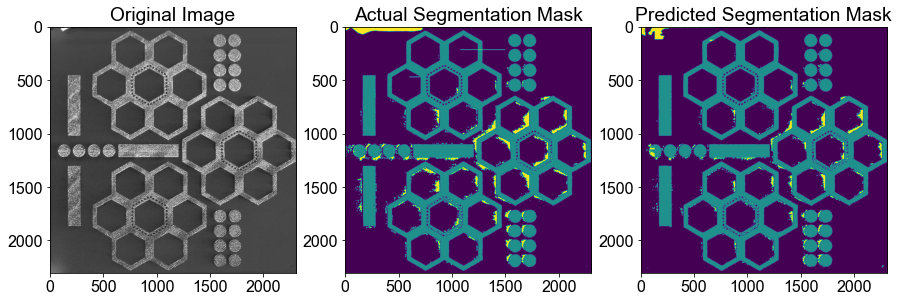

0000008
MeanIoU= 0.845


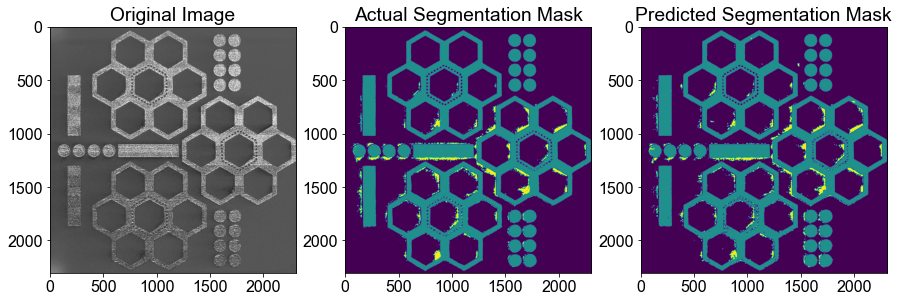

In [9]:
# Visualize results

# Since a well-trained model is available, we use it for demonstration.
cl_model = tf.keras.models.load_model('saved_models/CL_100_32_8e05_HoldoutPart0708.h5')

visualize_results_testset(cl_model, imageDictTest, segMaskDictTest,
                              testClients, clientIdentifierDict)